In [1]:
#https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [2]:
#text = "Here is the sentence I want embeddings for."
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"
#print('marked_text:',marked_text)

tokenized_text = tokenizer.tokenize(marked_text)
#print (len(tokenized_text),'tokenized_text:',tokenized_text)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#print(len(indexed_tokens),'indexed_tokens:',indexed_tokens)
#for tup in zip(tokenized_text, indexed_tokens):
#  print (tup)

segments_ids = [1] * len(tokenized_text)
print (len(segments_ids),'segments_ids:',segments_ids)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# If you have a GPU, put everything on cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #hhu
print(device)
if device == 'cuda':
    tokens_tensor = tokens_tensor.to('cuda')
    segments_tensors = segments_tensors.to('cuda')
    model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

print(segments_tensors)
print(type(encoded_layers),len(encoded_layers))
print(type(encoded_layers[0]),len(encoded_layers[0]))
print(encoded_layers[11].shape)

22 segments_ids: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
cuda
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
<class 'list'> 12
<class 'torch.Tensor'> 1
torch.Size([1, 22, 768])


torch.Size([22, 768])
torch.Size([768, 22])
torch.Size([22, 22])
torch.Size([22, 22])
y= torch.Size([22, 768])
torch.Size([1, 22])
bank ['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']
tensor([[ 32.7842,  61.4429,  97.6800, 151.8367,  92.5404, 119.3528, 242.7067,
         154.8098,  33.1573, 104.3848, 230.2765, 143.0902,  85.3533,  68.7504,
          62.0727,  58.7767,  97.2471, 109.6828, 118.1705, 139.8130,  32.8859,
          96.1952]])


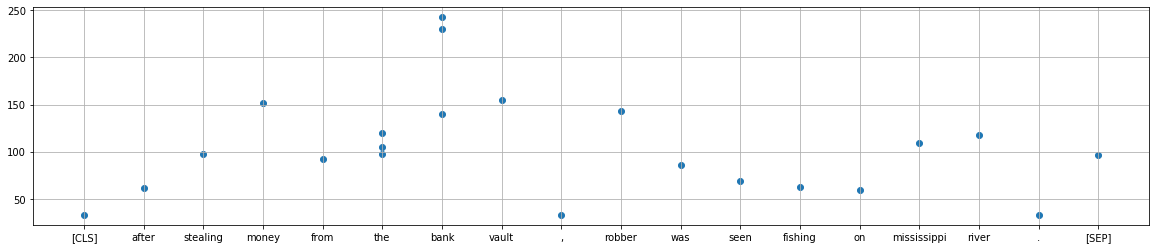

In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

sen1 = encoded_layers[11][-1,:,:]
print(sen1.shape)
sen2 = sen1.transpose(0,1)
print(sen2.shape)
rw = torch.mm(sen1,sen2)  #torch.bmm(sen1,sen2) for 3 dimensional
print(rw.shape)
weight = F.softmax(rw,dim=1)
print(weight.shape)

y = torch.mm(weight, sen1)
print('y=',y.shape)
 
i = 6
a1 =torch.mm(sen1[i].view(1,-1),y.transpose(0,1))
print(a1.shape)
print( tokenized_text[i],tokenized_text)
print(a1)
plt.figure(figsize=(20,4))
plt.scatter(tokenized_text,a1[0])
plt.grid()

In [4]:
#### Here after model described by 
#http://www.peterbloem.nl/blog/transformers
#and code from github 
#https://github.com/pbloem/former

import util
from util import *

import torch
from torch import nn
import torch.nn.functional as F

import random, math

class SelfAttentionWide(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
       :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e) 
        queries = self.toqueries(x).view(b, t, h, e)  
        values  = self.tovalues(x) .view(b, t, h, e)  

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)
    

class TransformerBlock(nn.Module):

    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()

        self.attention = SelfAttentionWide(emb, heads=heads, mask=mask) if wide \
                    else SelfAttentionNarrow(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

class GTransformer(nn.Module):
    """
    Transformer for generating text (character by character).
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, wide=False):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=True, wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_tokens)

    def forward(self, x):
        """
        :param x: A (batch, sequence length) integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = x.cuda()  #self.token_embedding(x)  #hhu
        b, t, e = tokens.size()

#        positions = self.pos_embedding(torch.arange(t, device='d()'))[None, :, :].expand(b, t, e)
        positions = self.pos_embedding(torch.arange(t,device='cuda'))[None, :, :].expand(b, t, e)
        x = tokens + positions

        x = self.tblocks(x)

        x = self.toprobs(x.view(b*t, e)).view(b, t, self.num_tokens)

        return F.log_softmax(x, dim=2)

In [5]:
embedding_size = 768
emb = embedding_size
num_heads = 8
depth = 1
seq_length = 22
num_tokens = embedding_size
wide = True

model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=seq_length, \
                     num_tokens=num_tokens, wide=wide)
if torch.cuda.is_available():
    model.cuda()

sen2 = sen1.view(1,sen1.size()[0], sen1.size()[1])
print(sen2.shape)

yy = model(sen2)  # model
yy = yy[-1,:,:]
print(yy.shape,sen1.shape)



torch.Size([1, 22, 768])
torch.Size([22, 768]) torch.Size([22, 768])


torch.Size([1, 22])
river ['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


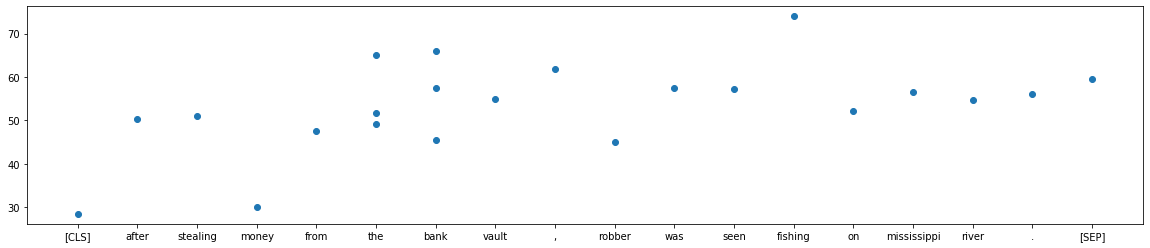

In [6]:
i = 18
sen1 = sen1.to('cuda')
a1 = torch.mm(sen1[i].view(1,-1),yy.transpose(0,1))
print(a1.shape)
print( tokenized_text[i],tokenized_text)

a1 = a1.cpu() #Move tensor from cuda to cpu

plt.figure(figsize=(20,4))
plt.scatter(tokenized_text,a1[0].detach().numpy())